# **Overview**

# **Library and Configurations**

In [2]:
import sys
sys.path.append("..")

import importlib

from warnings import filterwarnings
filterwarnings('ignore')

# Core Library
import pandas as pd
import numpy as np
import math
from pathlib import Path

# Visualization tools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Path tools
import os
import glob

# Computer vision tools
import cv2
import re

# Configuration
from src.config import config


# Source code helper
import src.plot_label_extractor as labelex
import src.features as features
def r(module=labelex):
    importlib.reload(module)

r()

np.printoptions(legacy="1.25")

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

print('Library Ready!')

Library Ready!


# **Plot Size Exploration**

In [2]:
import cv2
import numpy as np
from pathlib import Path

# root folder
train_dir = config.paths.raw / "Train"

shapes = []
failed = []

for loc_dir in train_dir.iterdir():
    if not loc_dir.is_dir():
        continue

    for img_path in loc_dir.glob("*.png"):
        img = cv2.imread(str(img_path))
        if img is None:
            failed.append(img_path)
            continue

        h, w, c = img.shape
        shapes.append((h, w, c))

shapes = np.array(shapes)

print(f"Total images read : {len(shapes)}")
print(f"Failed images    : {len(failed)}")

mean_shape = shapes.mean(axis=0)
std_shape  = shapes.std(axis=0)

print(f"Mean shape (H, W, C): {mean_shape}")
print(f"Std  shape (H, W, C): {std_shape}")

Total images read : 1152
Failed images    : 0
Mean shape (H, W, C): [ 700. 1500.    3.]
Std  shape (H, W, C): [0. 0. 0.]


In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_plot_borders(
    image: np.ndarray,
    side_border_fn,
    top_border_fn,
    title: str | None = None
):
    # --- detect side borders ---
    side = side_border_fn(image)
    left_x  = side["left"]
    right_x = side["right"]

    # --- detect top border ---
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    top_y = top_border_fn(
        gray,
        plot_x_start=left_x,
        plot_x_end=right_x
    )

    # --- plot ---
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    plt.figure(figsize=(12, 5))
    plt.imshow(img_rgb)
    plt.axis("off")

    # vertical borders
    plt.axvline(left_x,  color="lime", linewidth=2, label="Left border")
    plt.axvline(right_x, color="lime", linewidth=2, label="Right border")

    # top border
    if top_y is not None:
        plt.axhline(top_y, color="red", linewidth=2, label="Top border")

    if title:
        plt.title(title)

    plt.legend(loc="upper right")
    plt.show()


In [4]:
lefts, rights, tops = [], [], []

train_dir = config.paths.raw / "Train"

for loc_dir in train_dir.iterdir():
    if not loc_dir.is_dir():
        continue

    for img_path in loc_dir.glob("*.png"):
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        side = extraction.detect_plot_side_border(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        top  = extraction.detect_plot_top_border(
            gray,
            side["left"],
            side["right"]
        )

        lefts.append(side["left"])
        rights.append(side["right"])
        tops.append(top)

In [5]:
lefts  = np.array(lefts)
rights = np.array(rights)
tops   = np.array([t for t in tops if t is not None])

print("Left border  :", lefts.min(), lefts.max(), lefts.std())
print("Right border :", rights.min(), rights.max(), rights.std())
print("Top border   :", tops.min(), tops.max(), tops.std())

Left border  : 61 70 4.423144694035568
Right border : 1462 1486 1.1290223018278653
Top border   : 82 82 0.0


In [6]:
from collections import Counter

print("Unique left border", dict(Counter(lefts)))
print("Unique right border", dict(Counter(rights)))

Unique left border {np.int64(70): 682, np.int64(61): 470}
Unique right border {np.int64(1486): 1147, np.int64(1471): 1, np.int64(1468): 2, np.int64(1481): 1, np.int64(1462): 1}


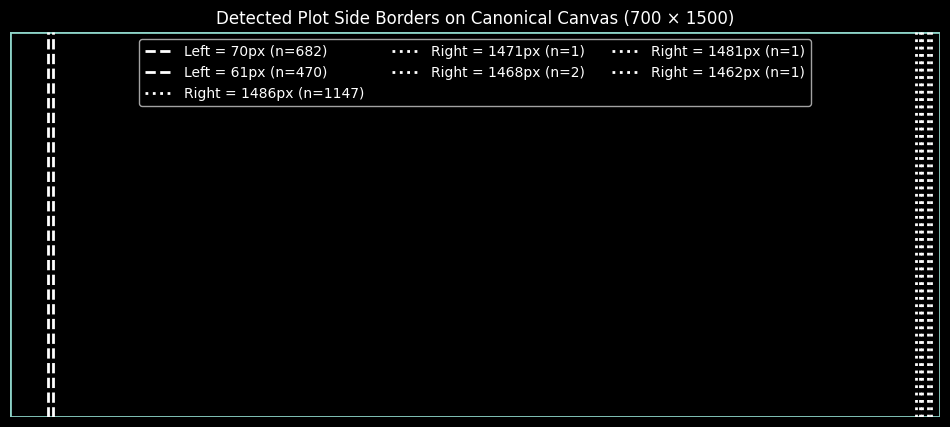

In [7]:
import matplotlib.pyplot as plt

# canonical canvas size
H, W = 700, 1500

left_borders  = dict(Counter(lefts))
right_borders = dict(Counter(rights))

plt.figure(figsize=(12, 5))
plt.xlim(0, W)
plt.ylim(H, 0)   # invert Y-axis to match image coordinates
plt.axis("off")

# draw canvas boundary
plt.plot([0, W, W, 0, 0], [0, 0, H, H, 0], linewidth=2)

# draw left borders
for x, cnt in left_borders.items():
    plt.axvline(
        x,
        linestyle="--",
        linewidth=2,
        label=f"Left = {x}px (n={cnt})"
    )

# draw right borders
for x, cnt in right_borders.items():
    plt.axvline(
        x,
        linestyle=":",
        linewidth=2,
        label=f"Right = {x}px (n={cnt})"
    )

plt.title("Detected Plot Side Borders on Canonical Canvas (700 × 1500)")
plt.legend(loc="upper center", ncol=3)
plt.show()

# **Demo**

In [2]:
location = "Admiralty".replace(" ", "_")
year = 2010

demo_path = config.paths.raw/f"Train/{location}/Plot_Daily_Rainfall_Total_mm_{year}.png"
demo_csv = config.paths.raw/f"Train/{location}/Data_Gabungan_Lainnya_{year}.csv"
demo_image = cv2.imread(demo_path)
demo_df = pd.read_csv(demo_csv)

params = {"image_path":demo_path,
    "total_days":len(demo_df),
    "debug":True}

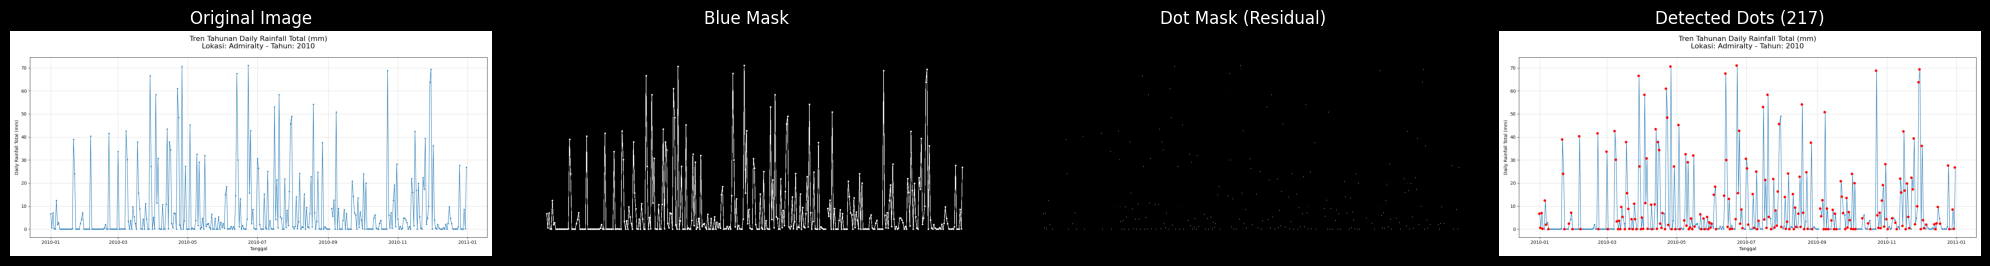

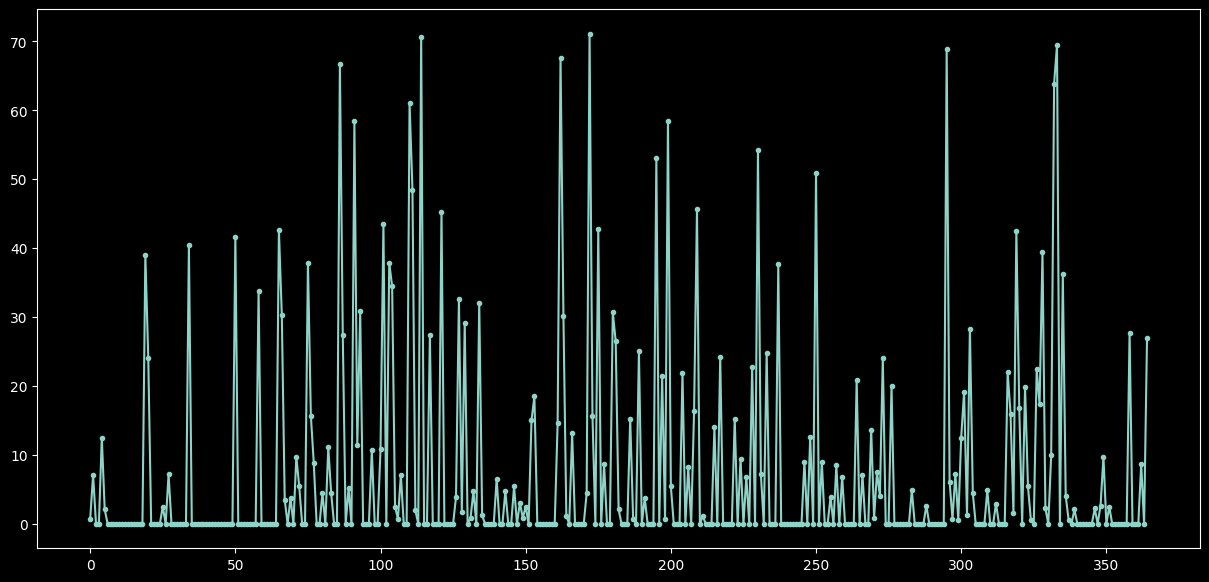

In [3]:
r()
demo = extraction.extract_rainfall_from_plot(
    **params
)

plt.figure(figsize=(15,7))
plt.plot(demo, marker='o', markersize=3)

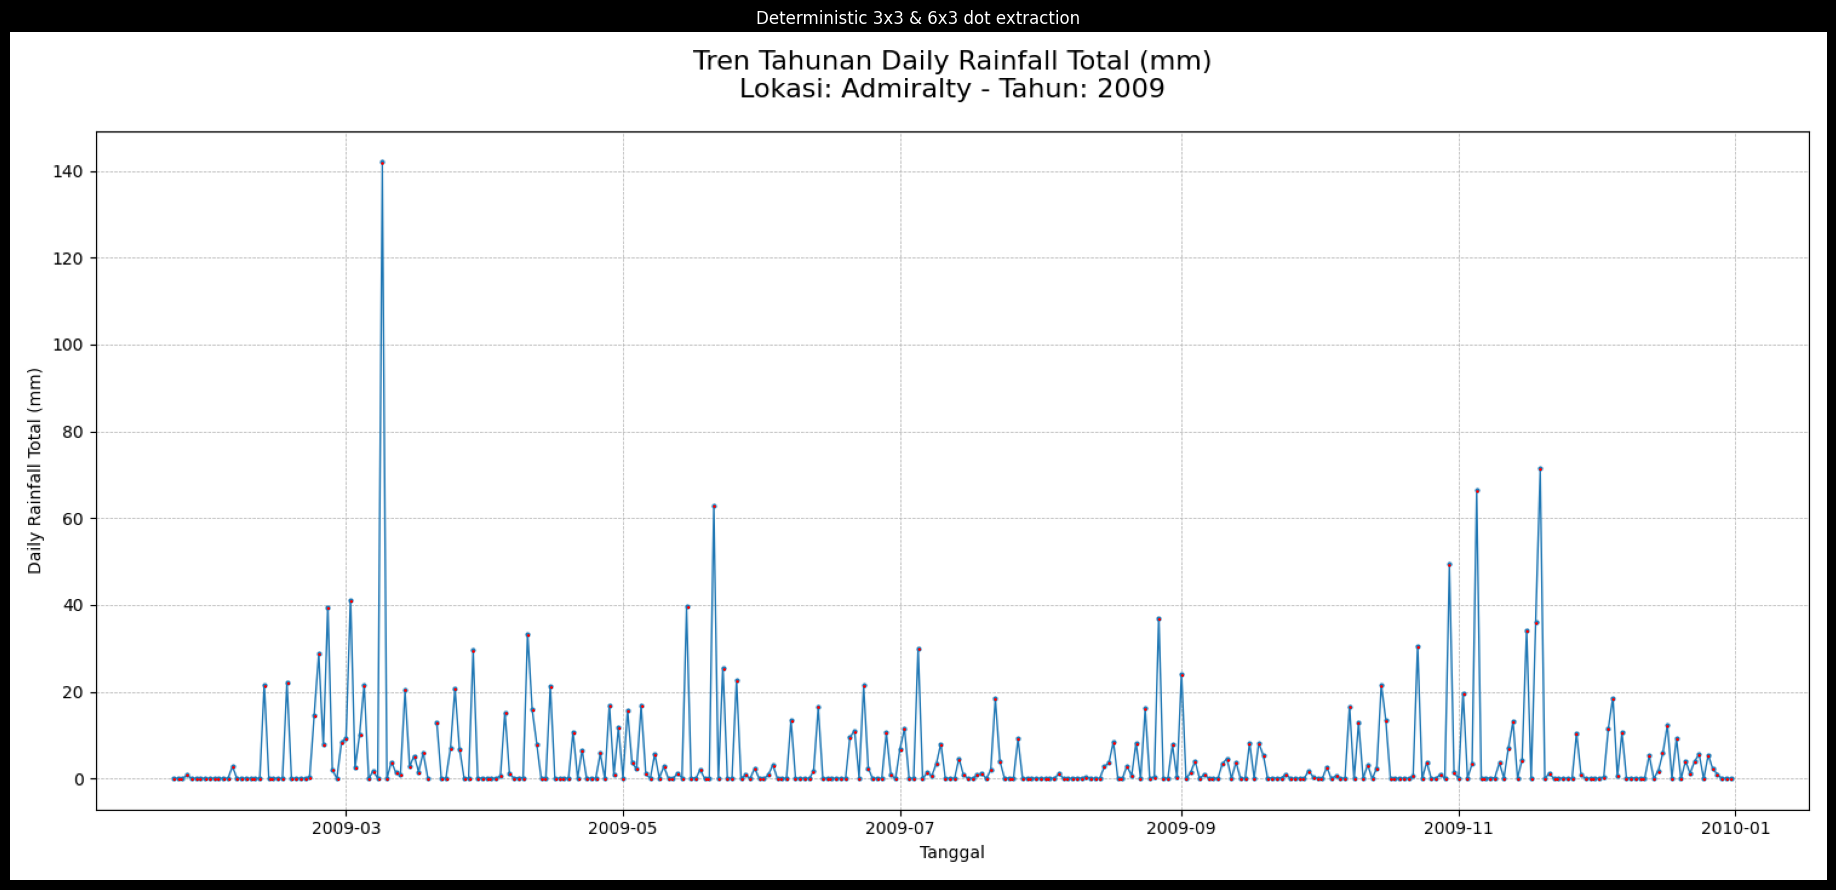

343


In [ ]:
def detect_color_mask(
    boundaries,
    image_bgr,
    target_rgb=(31, 119, 180),
    tolerance=5,
    pad=3,
    y_margin=80,
    debug=False,
):
    target_bgr = np.array(target_rgb[::-1], dtype=np.int16)
    H, W, _ = image_bgr.shape

    x0 = max(1, int(boundaries["data_start"]) - pad)
    x1 = min(W - 2, int(boundaries["data_end"]) + pad)

    y0 = y_margin
    y1 = H - y_margin

    img_crop = image_bgr[y0:y1, x0:x1]
    Hc, Wc, _ = img_crop.shape

    mask = np.zeros((H, W), dtype=np.uint8)

    for yc in range(1, Hc - 1):
        for xc in range(1, Wc - 1):
            patch = img_crop[yc-1:yc+2, xc-1:xc+2].astype(np.int16)
            if np.max(np.abs(patch - target_bgr)) <= tolerance:
                mask[y0 + yc, x0 + xc] = 255

    blue_mask = labelex.extract_blue_mask(image_bgr)
    line_presence = np.zeros(x1 - x0, dtype=np.uint8)

    for xi in range(x0, x1):
        col = blue_mask[y0:y1, xi]
        if np.count_nonzero(col) >= 1:
            line_presence[xi - x0] = 1

    if debug:
        dbg = image_bgr.copy()
        cv2.rectangle(
            dbg,
            (x0, y0),
            (x1, y1),
            (0, 255, 0),
            2
        )
        plt.figure(figsize=(6, 4))
        plt.imshow(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB))
        plt.title("Fixed plot crop (explicit margins)")
        plt.axis("off")
        plt.show()

    return mask, line_presence, (x0, x1)


def extract_dots(mask):
    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    dots = []

    for cid in range(1, num):
        x, y, w, h, area = stats[cid]

        ys, xs = np.where(labels == cid)

        if w >= 2*h:
            x_mid = np.median(xs)

            left = xs <= x_mid
            right = xs > x_mid

            if left.any() and right.any():
                lx = int(np.median(xs[left]))
                ly = int(np.median(ys[left]))
                rx = int(np.median(xs[right]))
                ry = int(np.median(ys[right]))
                dots.append((lx, ly))
                dots.append((rx, ry))
            else:
                dots.append((int(xs.mean()), int(ys.mean())))
            continue

        dots.append((int(xs.mean()), int(ys.mean())))

    return dots

location = "Admiralty".replace(" ", "_")
year = 2009

demo_path = config.paths.raw/f"Train/{location}/Plot_Daily_Rainfall_Total_mm_{year}.png"
demo_csv = config.paths.raw/f"Train/{location}/Data_Gabungan_Lainnya_{year}.csv"
demo_image = cv2.imread(demo_path)
demo_df = pd.read_csv(demo_csv)

import src.plot_label_extractor as labelex

boundaries = labelex.find_data_boundaries(demo_image)

points, blue_presence, (x0, x1) = detect_color_mask(
    boundaries=boundaries,
    image_bgr=demo_image,
    target_rgb=(31, 119, 180),
    tolerance=7
)

dots_per_pixel = extract_dots(points)
overlay_red_points(
    image_bgr=demo_image,
    points=dots,
    title="Deterministic 3x3 & 6x3 dot extraction"
)

print(len(dots_per_pixel))

In [5]:
def overlay_red_points(
    image_bgr,
    points,
    title="Exact 3x3 RGBA(88,153,198) detection",
):
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(50, 20))
    plt.imshow(img_rgb)

    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    plt.scatter(xs, ys, c="red", s=9, zorder=1)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def overlay_red_mask(
    image_bgr,
    mask,
    title="Overlay detected mask pixels",
):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    ys, xs = np.where(mask > 0)

    plt.figure(figsize=(50, 18))
    plt.imshow(img_rgb)

    plt.scatter(xs, ys, c="red", s=1, zorder=2)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

365 []


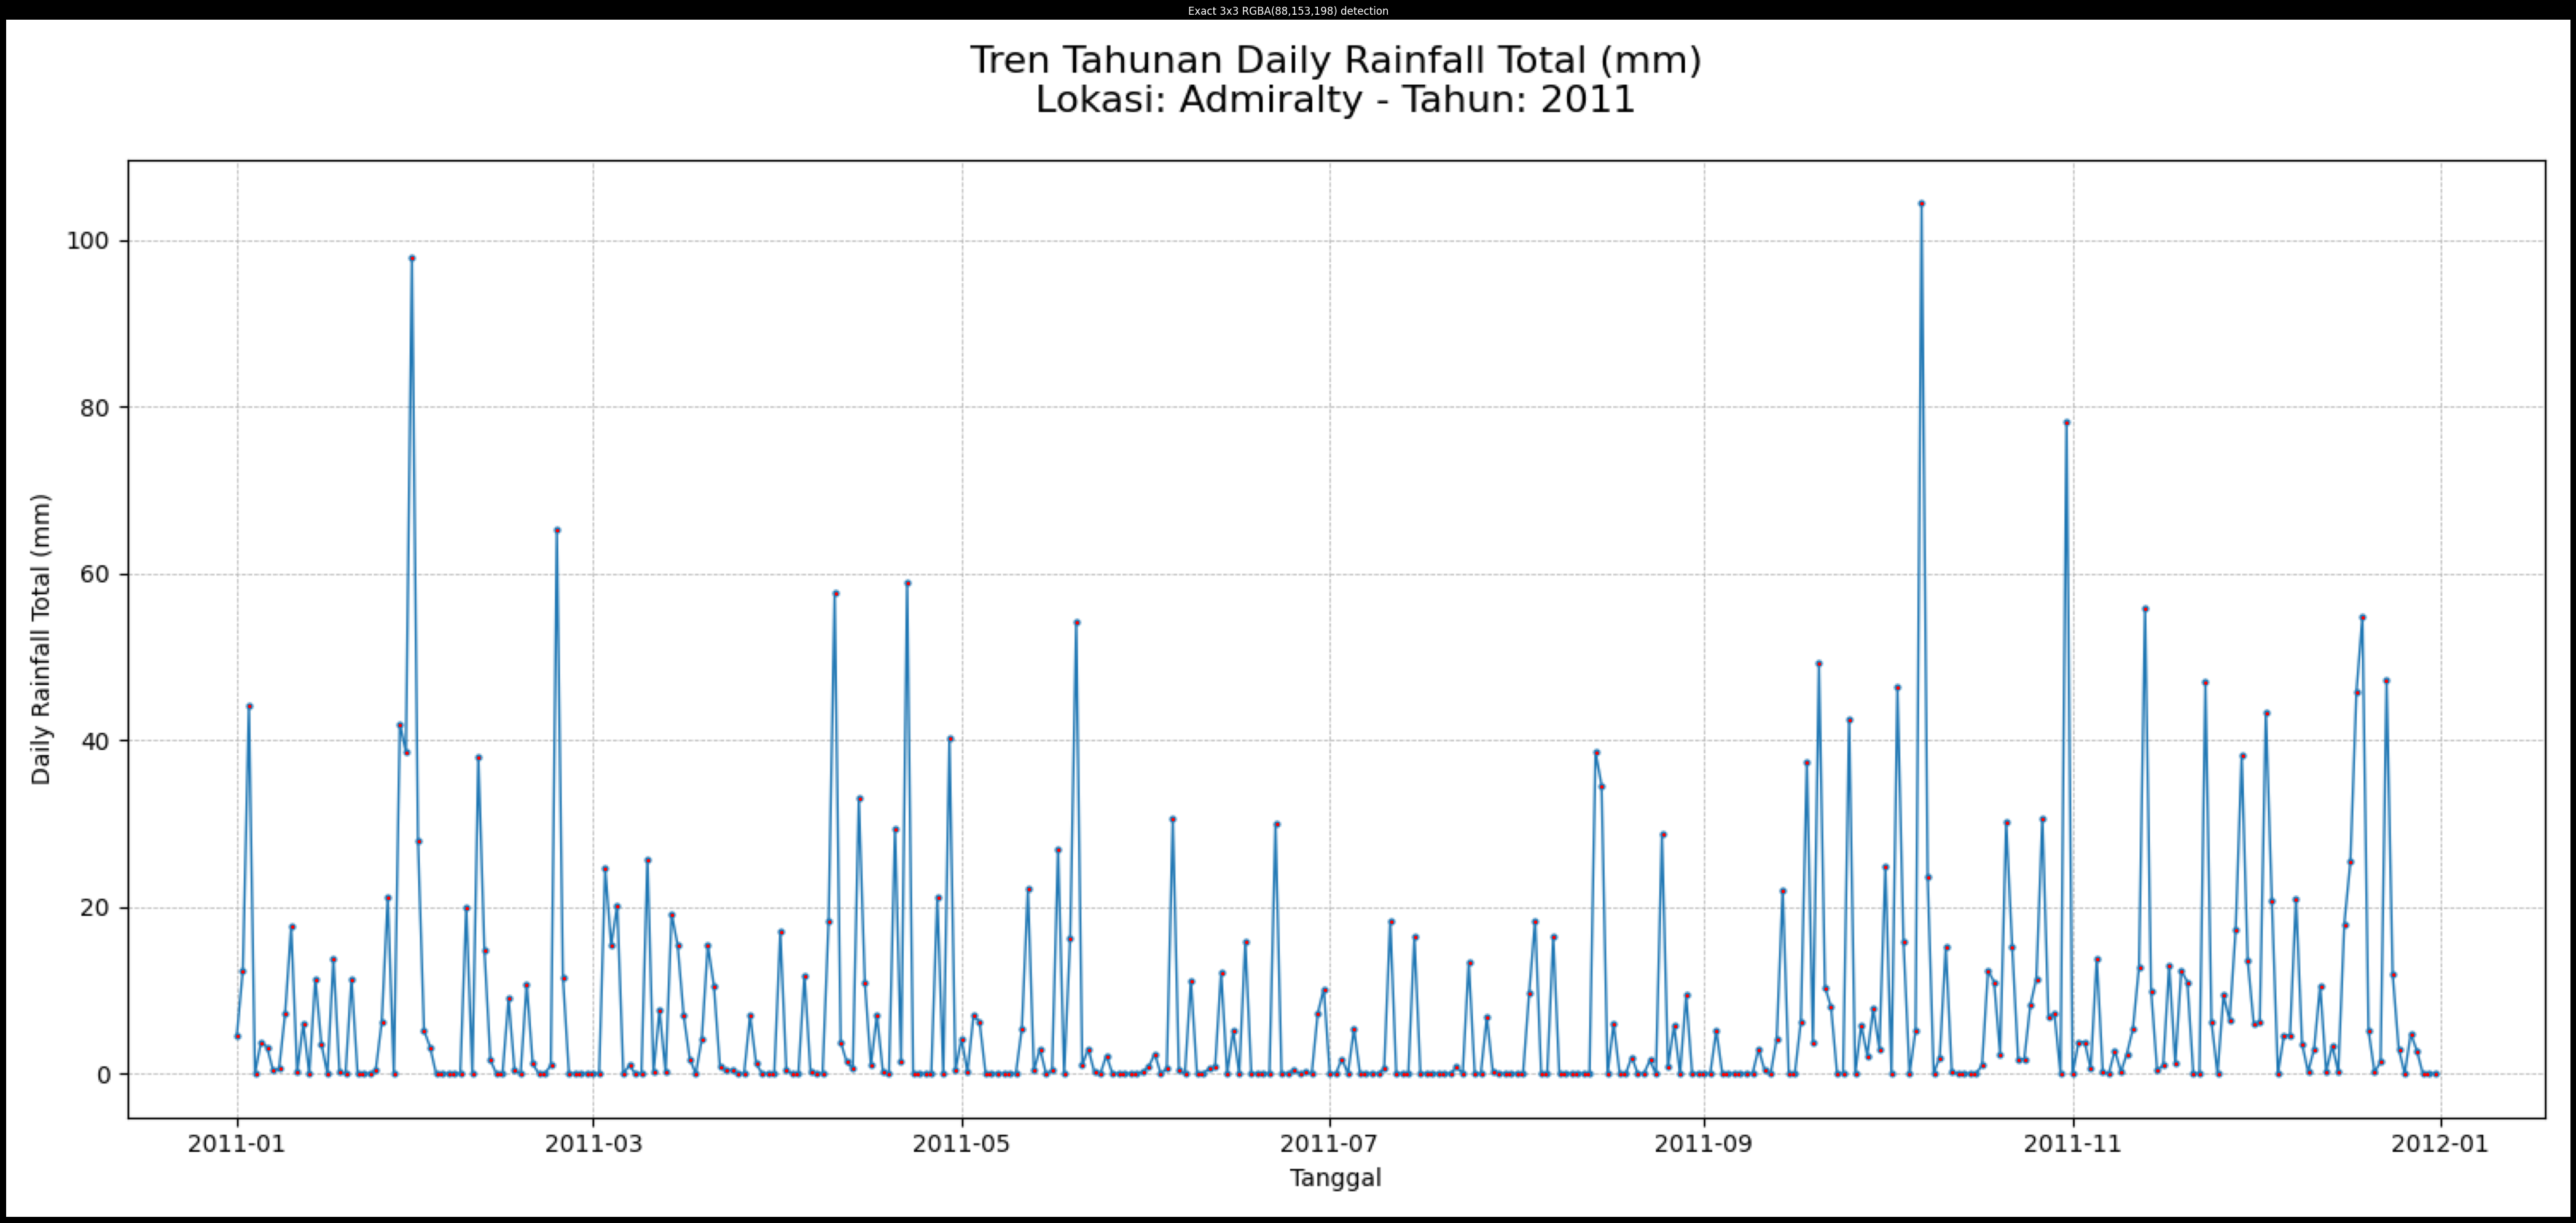

In [ ]:
def detect_dot_mask(
    boundaries,
    image_bgr,
    target_rgb=(31, 119, 180),
    tolerance=5,
    pad=2,
    y_margin=80,
):
    H, W, _ = image_bgr.shape
    target_bgr = np.array(target_rgb[::-1], dtype=np.int16)

    x0 = max(0, int(boundaries["data_start"]) - pad)
    x1 = min(W, int(boundaries["data_end"]) + pad + 1)
    y0 = y_margin
    y1 = H - y_margin

    roi = image_bgr[y0:y1, x0:x1].astype(np.int16)

    diff = np.abs(roi - target_bgr)
    color_mask = np.all(diff <= tolerance, axis=2).astype(np.uint8)

    kernel = np.ones((3, 3), dtype=np.uint8)

    dot_roi = cv2.morphologyEx(
        color_mask,
        cv2.MORPH_HITMISS,
        kernel
    )

    mask = np.zeros((H, W), dtype=np.uint8)
    mask[y0:y1, x0:x1] = dot_roi * 255

    return mask, (x0, x1)


def extract_dots(mask):
    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    dots = []

    for cid in range(1, num):
        x, y, w, h, area = stats[cid]

        ys, xs = np.where(labels == cid)

        if w >= 2*h:
            x_mid = np.median(xs)

            left = xs <= x_mid
            right = xs > x_mid

            if left.any() and right.any():
                lx = int(np.median(xs[left]))
                ly = int(np.median(ys[left]))
                rx = int(np.median(xs[right]))
                ry = int(np.median(ys[right]))
                dots.append((lx, ly))
                dots.append((rx, ry))
            else:
                dots.append((int(xs.mean()), int(ys.mean())))
            continue

        dots.append((int(xs.mean()), int(ys.mean())))

    return dots

def detect_color_presence(image_bgr, boundaries):
    x0 = boundaries["data_start"]
    x1 = boundaries["data_end"]

    blue_mask = labelex.extract_blue_mask(image_bgr)
    color_presence = np.zeros(x1 - x0, dtype=np.uint8)

    for xi in range(x0, x1):
        col = blue_mask[:, xi]
        if np.count_nonzero(col) >= 1:
            color_presence[xi - x0] = 1

    gaps = []
    in_gap = False
    start = None

    for i, v in enumerate(color_presence):
        if v == 0 and not in_gap:
            in_gap = True
            start = i

        elif v == 1 and in_gap:
            gaps.append((start, i - 1))
            in_gap = False

    if in_gap:
        gaps.append((start, len(color_presence) - 1))

    return gaps

location = "Ang Mo Kio".replace(" ", "_")
year = 2011

def generate_demo(location, year):
    location = location.replace(" ", "_")
    demo_path = config.paths.raw/f"Train/{location}/Plot_Daily_Rainfall_Total_mm_{year}.png"
    demo_csv = config.paths.raw/f"Train/{location}/Data_Gabungan_Lainnya_{year}.csv"
    demo_image = cv2.imread(demo_path)
    demo_df = pd.read_csv(demo_csv)

    return demo_path, demo_csv, demo_image, demo_df

demo_path, demo_csv, demo_image, demo_df = generate_demo("Admiralty", 2011)

boundaries = labelex.find_data_boundaries(demo_image)

mask, (x0, x1) = detect_dot_mask(
    boundaries,
    demo_image,
    target_rgb=(31, 119, 180),
    tolerance=3,
    pad=10,
    y_margin=80,
)

dots = extract_dots(mask)
blue_presence = detect_color_presence(demo_image, boundaries)

print(len(dots), blue_presence)
overlay_red_points(image_bgr=demo_image, points=dots)

In [ ]:
def allocate_missing_slots(
    missing_pixel_ranges,
    n_missing,
):
    gaps = missing_pixel_ranges
    gap_lens = np.array([b - a + 1 for a, b in gaps], dtype=float)

    if n_missing <= 0 or len(gaps) == 0:
        return [0] * len(gaps)

    weights = gap_lens / gap_lens.sum()
    alloc_raw = weights * n_missing
    alloc = np.floor(alloc_raw).astype(int)

    for i in range(len(alloc)):
        if gap_lens[i] > 0 and alloc[i] == 0:
            alloc[i] = 1

    for i, (a, b) in enumerate(gaps):
        if a != 0 and 1 < alloc_raw[i] < 2:
            alloc[i] = 1

    def total():
        return alloc.sum()

    while total() > n_missing:
        candidates = [
            i for i, (a, _) in enumerate(gaps)
            if a != 0 and alloc[i] > 1
        ]
        if not candidates:
            break
        i = min(candidates, key=lambda j: gap_lens[j])
        alloc[i] -= 1

    while total() < n_missing:
        if gaps[0][0] == 0:
            alloc[0] += 1
        else:
            i = int(np.argmax(gap_lens))
            alloc[i] += 1

    return alloc.tolist()

def map_points_from_gaps(
    missing_pixel_ranges,
    alloc,
):
    missing_points = []

    for (a, b), k in zip(missing_pixel_ranges, alloc):
        if k <= 0:
            continue

        if a == 0:
            xs = np.linspace(0, b, k + 2)[1:-1]
        else:
            xs = np.linspace(a, b, k + 2)[1:-1]

        for x in xs:
            missing_points.append((x, np.nan))

    return missing_points

def build_series(
    dots,
    missing_pixel_ranges,
    n_days,
):
    dots = [(x, y) for x, y in dots]

    n_missing = n_days - len(dots)
    print(f"missing: {n_missing}")
    if n_missing < 0:
        raise ValueError("More dots than n_days")

    alloc = allocate_missing_slots(
        missing_pixel_ranges,
        n_missing,
    )

    missing_points = map_points_from_gaps(
        missing_pixel_ranges,
        alloc,
    )

    all_points = dots + missing_points

    all_points.sort(key=lambda p: p[0])

    return all_points

n_days = len(demo_df)
n_missing = n_days - len(dots)

all_points = build_series(
    dots,
    blue_presence,
    n_days,
)

print(len(all_points), "==", n_days)
assert len(all_points) == n_days
print("NaN:", np.count_nonzero(np.isnan(all_points)))
print("Dots:", len(dots))

missing: 0
365 == 365
NaN: 0
Dots: 365


In [11]:
for year in range(1980, 2024):
    print("year", year)
    demo_path, demo_csv, demo_image, demo_df = generate_demo("Changi", year)
    n_days = len(demo_df)
    boundaries = labelex.find_data_boundaries(demo_image)

    mask, (x0, x1) = detect_dot_mask(
        boundaries,
        demo_image,
        target_rgb=(31, 119, 180),
        tolerance=3,
        pad=5,
        y_margin=80,
    )

    dots = extract_dots(mask)
    blue_presence = detect_color_presence(demo_image, boundaries)

    sx, sy = build_series(
        dots,
        blue_presence,
        n_days,
    )

year 1980
missing: 0
year 1981
missing: 0
year 1982
missing: 0
year 1983
missing: 0
year 1984
missing: 0
year 1985
missing: 0
year 1986
missing: 0
year 1987
missing: 0
year 1988
missing: 0
year 1989
missing: 0
year 1990
missing: 0
year 1991
missing: 0
year 1992
missing: 0
year 1993
missing: 0
year 1994
missing: 0
year 1995
missing: 0
year 1996
missing: 0
year 1997
missing: 0
year 1998
missing: 0
year 1999
missing: 0
year 2000
missing: 0
year 2001
missing: 0
year 2002
missing: 0
year 2003
missing: 0
year 2004
missing: 0
year 2005
missing: 0
year 2006
missing: 0
year 2007
missing: 0
year 2008
missing: 0
year 2009
missing: 0
year 2010
missing: 0
year 2011
missing: 0
year 2012
missing: 0
year 2013
missing: 0
year 2014
missing: 0
year 2015
missing: 0
year 2016
missing: 0
year 2017
missing: 0
year 2018
missing: 0
year 2019
missing: 0
year 2020
missing: 0
year 2021
missing: 0
year 2022
missing: 0
year 2023
missing: 0


In [275]:
def insert_missing_from_gaps(
    dots,
    missing_pixel_ranges,
    px_per_day
):
    dots = sorted(dots, key=lambda p: p[0])

    series_x = []
    series_y = []

    def add_missing_for_gap(a, b):
        gap_len = b - a + 1
        n_missing = gap_len / px_per_day
        if n_missing < 1.0:
            n_missing = 1.0

        for k in range(int(round(n_missing))):
            xm = a + (k + 0.5) * px_per_day
            series_x.append(xm)
            series_y.append(np.nan)

    first_x = dots[0][0]
    for a, b in missing_pixel_ranges:
        if b < first_x:
            add_missing_for_gap(a, b)

    for i, (x, y) in enumerate(dots):
        series_x.append(x)
        series_y.append(y)

        if i == len(dots) - 1:
            break

        x_next = dots[i + 1][0]

        for a, b in missing_pixel_ranges:
            if a > x and b < x_next:
                add_missing_for_gap(a, b)

    last_x = dots[-1][0]
    for a, b in missing_pixel_ranges:
        if a > last_x:
            add_missing_for_gap(a, b)

    return np.array(series_x), np.array(series_y), px_per_day

x, y, pixel = insert_missing_from_gaps(dots, blue_presence, px_per_day)
print(len(x), len(demo_df))

121 122


In [ ]:
def has_missing_between(x_left, x_right, missing_ranges):
    for a, b in missing_ranges:
        if a > x_left and b < x_right:
            return True
    return False

def build_missing_mask(x_grid, missing_pixel_ranges):
    """
    return boolean array: True = missing
    """
    missing = np.zeros(len(x_grid), dtype=bool)

    for i, x in enumerate(x_grid):
        for a, b in missing_pixel_ranges:
            if a <= x <= b:
                missing[i] = True
                break

    return missing

def map_dots_to_days(dots, x_grid):
    """
    dots: list[(x_pixel, y_pixel)]
    """
    y_series = np.full(len(x_grid), np.nan, dtype=float)

    for x, y in dots:
        idx = int(np.argmin(np.abs(x_grid - x)))
        y_series[idx] = y

    return y_series

def build_xy_series(dots, missing_pixel_ranges):
    dots = sorted(dots, key=lambda p: p[0])

    x_series = []
    y_series = []

    day = 0

    # 2. handle leading missing (sebelum dot pertama)
    first_x = dots[0][0]
    for a, b in missing_pixel_ranges:
        if b < first_x:
            x_series.append((a + b) // 2)
            y_series.append(np.nan)
            day += 1

    # 3. iterate dots
    for i, (x, y) in enumerate(dots):
        # assign dot
        x_series.append(x)
        y_series.append(y)
        day += 1

        # check missing before next dot
        if i < len(dots) - 1:
            x_next = dots[i + 1][0]
            if has_missing_between(x, x_next, missing_pixel_ranges):
                for a, b in missing_pixel_ranges:
                    if a > x and b < x_next:
                        x_missing = (a + b) // 2
                        break

                x_series.append(x_missing)
                y_series.append(np.nan)
                day += 1

    return np.array(x_series), np.array(y_series)

x, y = build_xy_series(dots, blue_presence)

In [106]:
x

array([  29,  135,  139,  141,  146,  150,  154,  156,  161,  165,  169,
        171,  176,  180,  184,  187,  191,  195,  199,  201,  206,  210,
        214,  216,  221,  225,  229,  232,  236,  240,  244,  247,  251,
        255,  259,  262,  266,  270,  274,  275,  277,  281,  285,  289,
        292,  296,  300,  304,  307,  311,  315,  319,  322,  326,  330,
        334,  337,  341,  345,  352,  356,  360,  364,  367,  371,  375,
        379,  382,  386,  390,  394,  396,  401,  405,  409,  412,  416,
        420,  424,  427,  431,  435,  439,  441,  446,  450,  454,  456,
        461,  465,  469,  472,  476,  480,  484,  487,  491,  495,  499,
        502,  506,  510,  514,  517,  521,  525,  529,  532,  536,  540,
        544,  546,  551,  555,  559,  562,  566,  570,  574,  576,  581,
        585,  589,  592,  596,  600,  604,  607,  611,  615,  619,  621,
        626,  630,  634,  636,  641,  645,  648,  652,  656,  660,  663,
        667,  671,  675,  677,  682,  686,  690,  6

In [100]:
def line_presence_to_is_missing(line_presence, x0, x1, n_days):
    pixel_per_day = (x1 - x0) / (n_days - 1)
    is_missing = np.zeros(n_days, dtype=bool)

    i = 0
    L = len(line_presence)

    while i < L:
        if line_presence[i] == 0:
            j = i
            while j < L and line_presence[j] == 0:
                j += 1

            gap_width = j - i
            n_missing = int(round(gap_width / pixel_per_day))
            start_day = int(round(i / pixel_per_day))

            for d in range(start_day, start_day + n_missing):
                if 0 <= d < n_days:
                    is_missing[d] = True

            i = j
        else:
            i += 1

    return is_missing

is_missing = line_presence_to_is_missing(
    blue_presence, x0, x1, len(demo_df)
)

In [ ]:
boundaries = extraction.find_data_boundaries(demo_image)

def build_daily_series(
    boundaries,
    dots,
    is_missing,
    n_days,
):
    series = np.full(n_days, np.nan, dtype=float)
    used   = np.zeros(n_days, dtype=bool)

    if len(dots) == 0:
        return series, None

    dots = sorted(dots, key=lambda p: p[0])
    xs = np.array([x for x, _ in dots], dtype=float)
    ys = np.array([y for _, y in dots], dtype=float)

    x_start = float(boundaries["data_start"])
    x_end   = float(boundaries["data_end"])
    step = (x_end - x_start) / (n_days - 1)

    raw_idx = (xs - x_start) / step
    day_idx = np.round(raw_idx).astype(int)
    day_idx = np.clip(day_idx, 0, n_days - 1)

    for i, d in enumerate(day_idx):

        if is_missing[d]:
            found = False
            for offset in range(1, n_days):
                for cand in (d - offset, d + offset):
                    if 0 <= cand < n_days and not is_missing[cand]:
                        d = cand
                        found = True
                        break
                if found:
                    break

            if not found:
                raise RuntimeError("No valid day found for dot")

        if not used[d]:
            series[d] = ys[i]
            used[d] = True
            continue

        for offset in range(1, n_days):
            left = d - offset
            right = d + offset

            if left >= 0 and not is_missing[left] and not used[left]:
                series[left] = ys[i]
                used[left] = True
                break

            if right < n_days and not is_missing[right] and not used[right]:
                series[right] = ys[i]
                used[right] = True
                break
        else:
            raise RuntimeError("No available day to assign dot")

    return series, day_idx

series, idx = build_daily_series(boundaries, dots, n_days=len(demo_df), is_missing=is_missing)

print("detected:", np.count_nonzero(~np.isnan(series)))
print("missing :", np.isnan(series).sum())

detected: 343
missing : 22


In [69]:
def nan_runs(series):
    isn = np.isnan(series)
    runs = []

    i = 0
    n = len(series)
    while i < n:
        if isn[i]:
            j = i
            while j < n and isn[j]:
                j += 1
            runs.append({
                "start_day": i,
                "end_day": j - 1,
                "length": j - i
            })
            i = j
        else:
            i += 1
    return runs

runs = nan_runs(series)
print("Amount of NaN Blocks:", len(runs))
print("Example:", runs[:5])

Amount of NaN Blocks: 7
Example: [{'start_day': 0, 'end_day': 15, 'length': 16}, {'start_day': 25, 'end_day': 25, 'length': 1}, {'start_day': 74, 'end_day': 74, 'length': 1}, {'start_day': 98, 'end_day': 98, 'length': 1}, {'start_day': 182, 'end_day': 182, 'length': 1}]


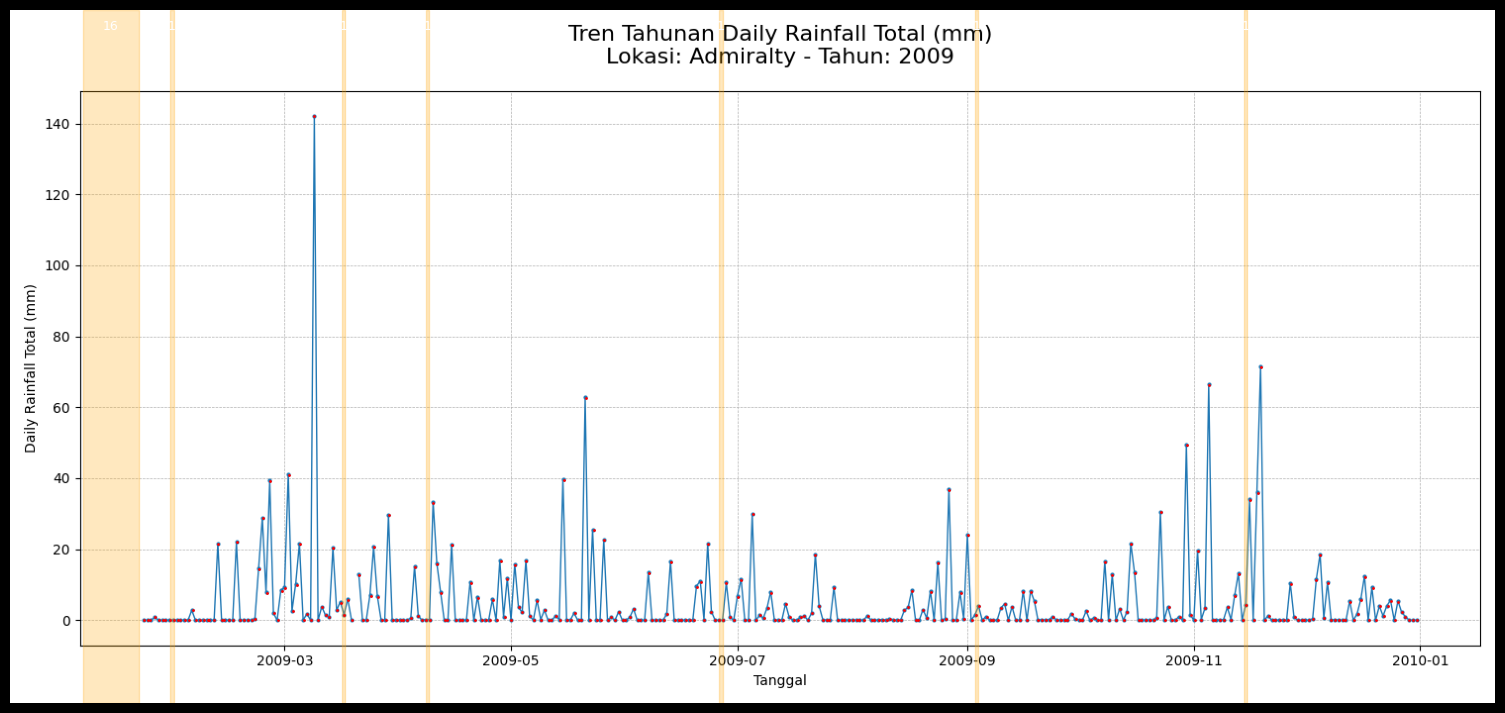

In [70]:
import cv2
import matplotlib.pyplot as plt

def overlay_nan_blocks(image_bgr, dots, runs, x0, step):
    img = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(20, 9))
    plt.imshow(img)

    # dots
    if dots:
        xs = [x for x, y in dots]
        ys = [y for x, y in dots]
        plt.scatter(xs, ys, s=1, c="red", zorder=3)

    # NaN blocks
    for r in runs:
        lx = x0 + step * r["start_day"]
        rx = x0 + step * (r["end_day"] + 1)
        plt.axvspan(lx, rx, color="orange", alpha=0.25, zorder=2)
        plt.text((lx+rx)/2, 20, f'{r["length"]}', ha='center', fontsize=9)

    plt.axis("off")
    plt.show()


overlay_nan_blocks(demo_image, dots, runs, boundaries["data_start"], step)

In [ ]:
from src import dots_extractor_v2 as extractorv2

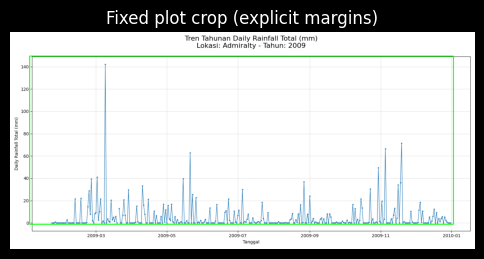

365

In [59]:
r(extractorv2)

location = "Admiralty"
year = 2009

demo_path = config.paths.raw/f"Train/{location}/Plot_Daily_Rainfall_Total_mm_{year}.png"
demo_csv = config.paths.raw/f"Train/{location}/Data_Gabungan_Lainnya_{year}.csv"
demo_image = cv2.imread(demo_path)
demo_df = pd.read_csv(demo_csv)

rainfall = extractorv2.extract_rainfall_from_plot(demo_path, demo_df, debug=True)
len(rainfall)

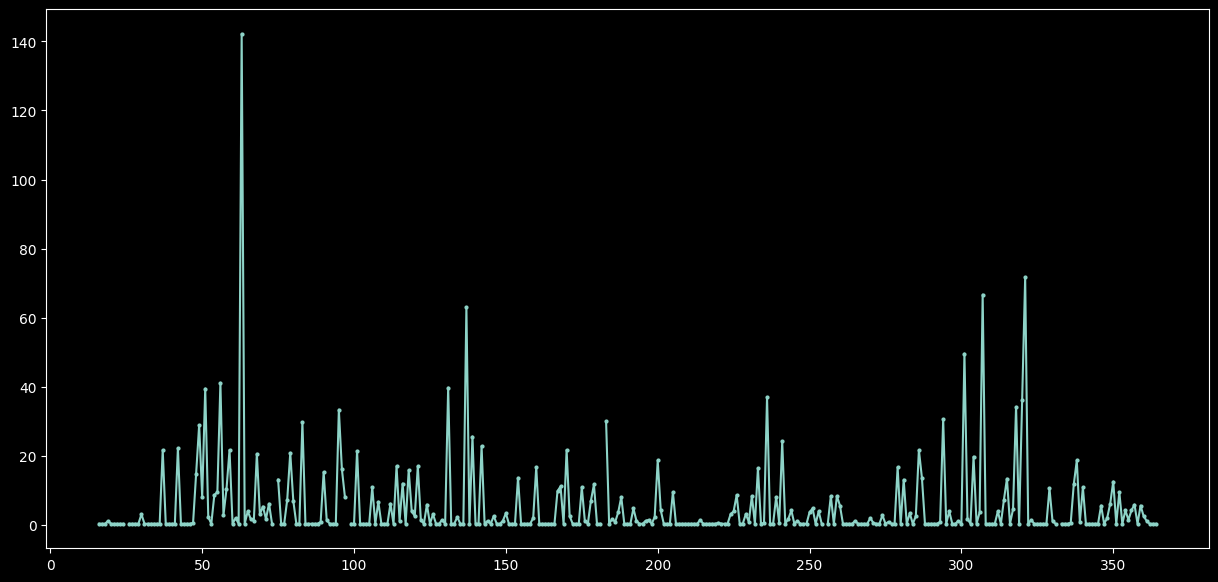

In [60]:
plt.figure(figsize=(15, 7))
plt.plot(rainfall, marker="o", markersize=2)

# **Label ROI Detection**

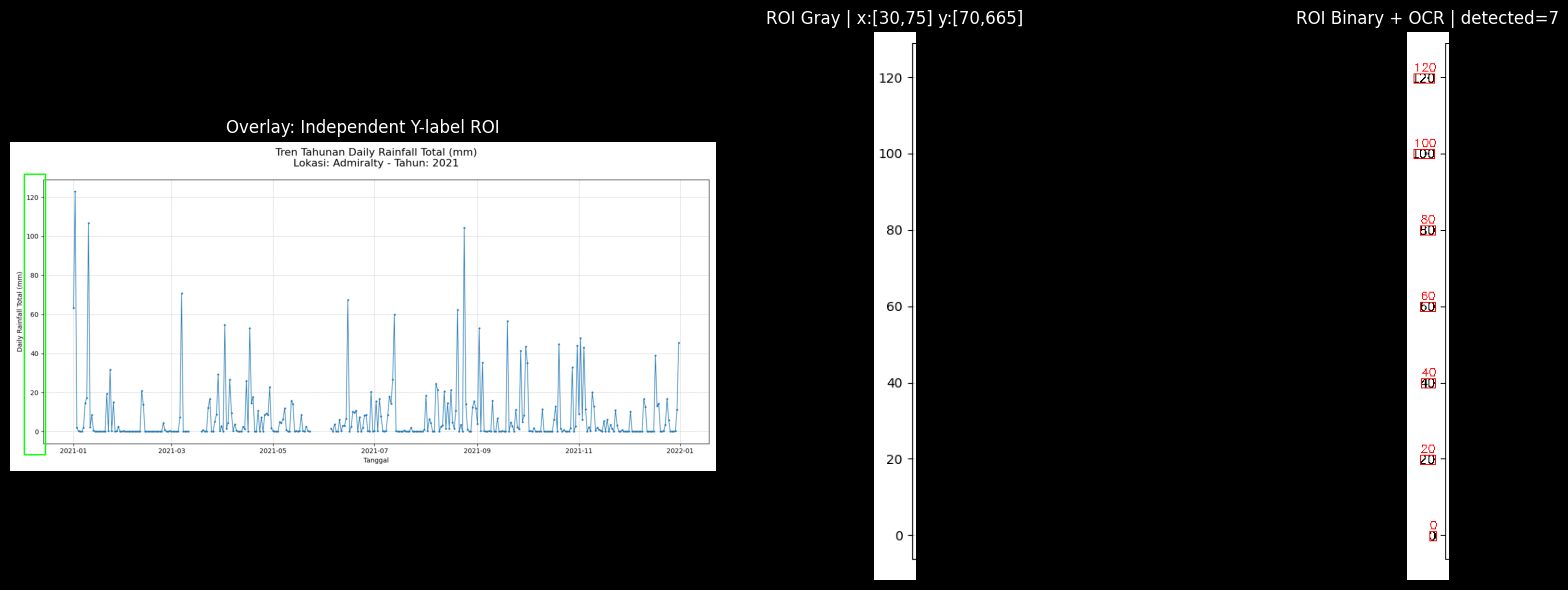

{'roi_coords': (30, 70, 75, 665),
 'detected_texts': ['120', '100', '80', '60', '40', '20', '0'],
 'num_boxes': 7}

In [3]:
def debug_y_label_ocr_independent(
    image: np.ndarray,
    x_start = 30,
    x_frac: float = 0.05,
    y_top_frac: float = 0.10,
    y_bot_frac: float = 0.95,
    show: bool = True
):
    h, w = image.shape[:2]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    x0 = x_start
    x1 = int(w * x_frac)

    y0 = int(h * y_top_frac)
    y1 = int(h * y_bot_frac)

    roi = gray[y0:y1, x0:x1]
    roi_bin = cv2.threshold(
        roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )[1]

    data = pytesseract.image_to_data(
        roi_bin,
        config="--oem 3 --psm 6 outputbase digits",
        output_type=pytesseract.Output.DICT
    )

    det = []
    for i, txt in enumerate(data["text"]):
        txt = (txt or "").strip()
        if not txt:
            continue

        x, y, w_, h_ = (
            data["left"][i],
            data["top"][i],
            data["width"][i],
            data["height"][i],
        )
        det.append((txt, x, y, w_, h_))

    overlay = image.copy()
    cv2.rectangle(overlay, (x0, y0), (x1, y1), (0, 255, 0), 2)

    roi_vis = cv2.cvtColor(roi_bin, cv2.COLOR_GRAY2BGR)
    for txt, x, y, w_, h_ in det:
        cv2.rectangle(
            roi_vis, (x, y), (x + w_, y + h_), (0, 0, 255), 1
        )
        cv2.putText(
            roi_vis,
            txt,
            (x, max(10, y - 3)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.4,
            (0, 0, 255),
            1,
        )

    if show:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Overlay: Independent Y-label ROI")
        axs[0].axis("off")

        axs[1].imshow(roi, cmap="gray")
        axs[1].set_title(f"ROI Gray | x:[{x0},{x1}] y:[{y0},{y1}]")
        axs[1].axis("off")

        axs[2].imshow(cv2.cvtColor(roi_vis, cv2.COLOR_BGR2RGB))
        axs[2].set_title(f"ROI Binary + OCR | detected={len(det)}")
        axs[2].axis("off")

        plt.tight_layout()
        plt.show()

    return {
        "roi_coords": (x0, y0, x1, y1),
        "detected_texts": [t[0] for t in det],
        "num_boxes": len(det),
    }

sample_image = config.paths.raw/'Train/Admiralty/Plot_Daily_Rainfall_Total_mm_2021.png'
image = cv2.imread(str(sample_image))

info = debug_y_label_ocr_independent(image)
info

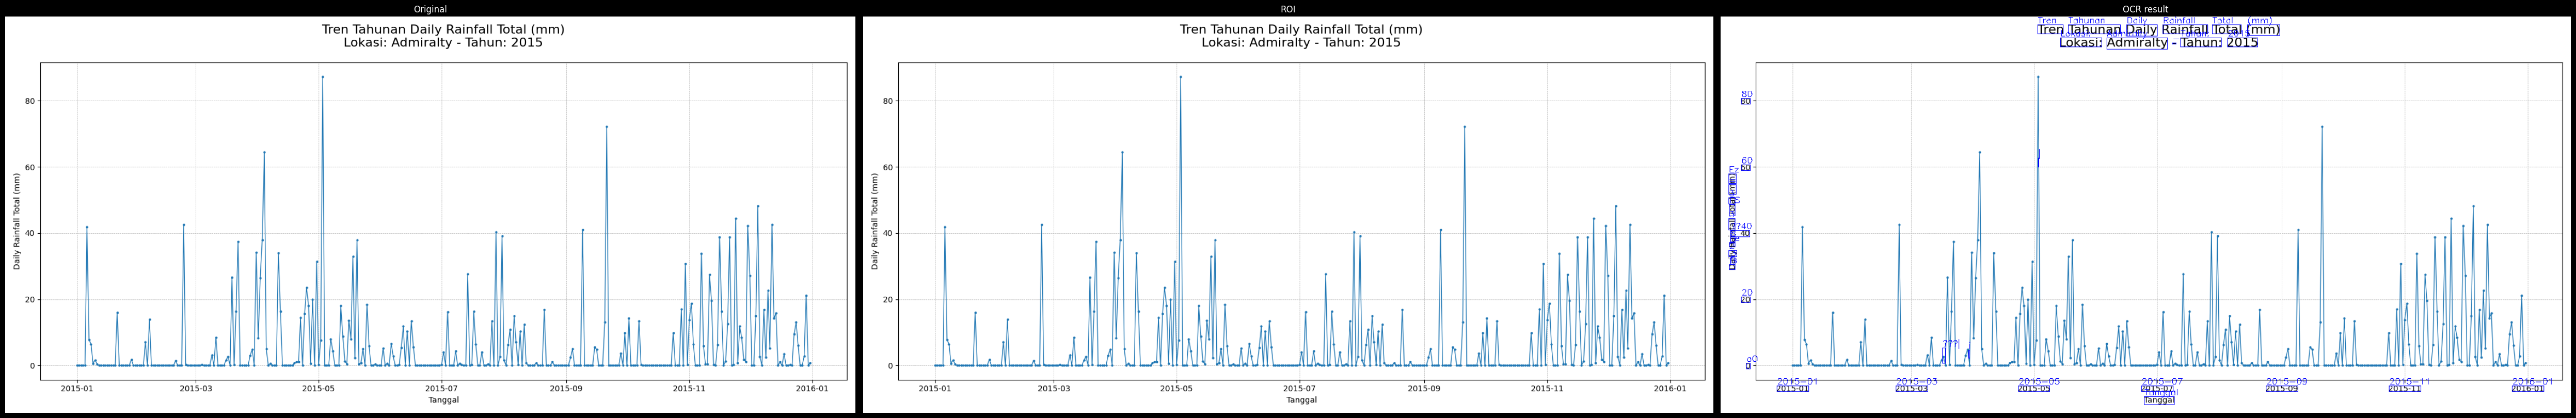

{'exists': False, 'x': 0, 'timestamp': Timestamp('2014-11-26 07:00:17.782407168'), 'method': 'border_fallback'}


In [5]:
def perform_ocr(
    image: np.ndarray,
    roi_x0: int = 0,
    roi_x1: int = 1500,
    roi_y0: int = 0,
    roi_y1: int = 700,
    show: bool = True
):
    import cv2, pytesseract, matplotlib.pyplot as plt

    roi = image[roi_y0:roi_y1, roi_x0:roi_x1]
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    bin_img = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )[1]

    data = pytesseract.image_to_data(
        bin_img,
        config="--psm 6",
        output_type=pytesseract.Output.DICT
    )

    det = []
    for i, txt in enumerate(data["text"]):
        txt = txt.strip()
        if not txt:
            continue
        x = data["left"][i]
        y = data["top"][i]
        w = data["width"][i]
        h = data["height"][i]
        det.append((txt, x, y, w, h))

    overlay = roi.copy()
    for txt, x, y, w, h in det:
        cv2.rectangle(overlay, (x, y), (x+w, y+h), (255, 0, 0), 1)
        cv2.putText(
            overlay, txt, (x, max(10, y-3)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1
        )

    if show:
        fig, axs = plt.subplots(1, 3, figsize=(50, 20))
        axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Original")
        axs[0].axis("off")

        axs[1].imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        axs[1].set_title("ROI")
        axs[1].axis("off")

        axs[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        axs[2].set_title("OCR result")
        axs[2].axis("off")

        plt.tight_layout()
        plt.show()

    return det

def extract_xticks_from_ocr(ocr_results, roi_x0=0):
    XTICK_PATTERN = re.compile(r"(\d{4})-(\d{2})")
    ticks = []

    for txt, x, y, w, h in ocr_results:
        m = XTICK_PATTERN.search(txt)
        if not m:
            continue

        year, month = m.groups()

        try:
            dt = pd.to_datetime(f"{year}-{month}")
        except Exception:
            continue

        x_center = roi_x0 + x + w / 2
        ticks.append((x_center, dt, txt))

    if len(ticks) < 2:
        raise RuntimeError("Not enough valid xticks detected")

    return ticks

def compute_pixel_time_slope(ticks):
    xs = np.array([x for x, _, _ in ticks])
    ts = np.array([t.value for _, t, _ in ticks])  # nanoseconds

    a, b = np.polyfit(xs, ts, 1)
    return a, b

def estimate_pixel_spacing(ticks):
    xs = np.array([x for x, _, _ in ticks])
    dx = np.diff(xs)
    return np.median(dx)

def estimate_missing_left_timestamp(
    ticks,
    plot_border_x,
    tolerance_ratio=0.4
):
    a, b = compute_pixel_time_slope(ticks)
    pixel_spacing = estimate_pixel_spacing(ticks)

    first_x, first_t, _ = ticks[0]

    candidate_x = first_x - pixel_spacing
    if candidate_x >= plot_border_x + tolerance_ratio * pixel_spacing:
        candidate_t = pd.to_datetime(int(a * candidate_x + b))
        return {
            "exists": True,
            "x": candidate_x,
            "timestamp": candidate_t,
            "method": "estimated_missing_tick"
        }

    border_t = pd.to_datetime(int(a * plot_border_x + b))
    return {
        "exists": False,
        "x": plot_border_x,
        "timestamp": border_t,
        "method": "border_fallback"
    }

sample_image = config.paths.raw/'Train/Admiralty/Plot_Daily_Rainfall_Total_mm_2015.png'
image = cv2.imread(str(sample_image))

ocr = perform_ocr(image)
ticks = extract_xticks_from_ocr(ocr)
result = estimate_missing_left_timestamp(
    ticks,
    plot_border_x=0
)

ticks
print(result)

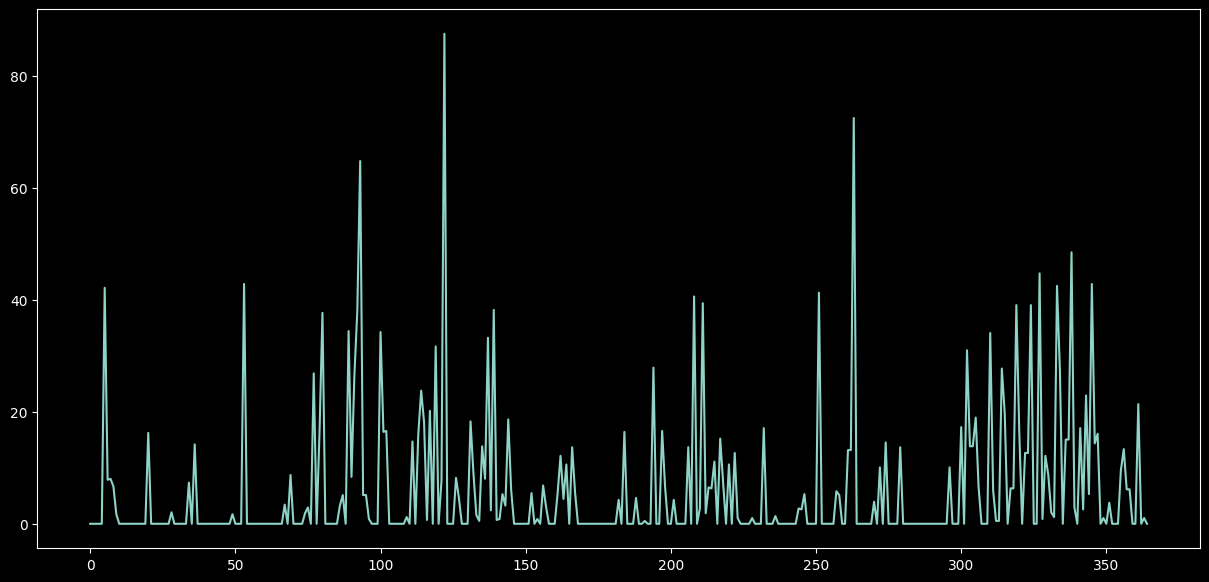

In [113]:
plot = extraction.extract_rainfall_from_plot(
    sample_image,
    total_days=365,
    scale=1,
    verbose = False,
    debug = False
)

plt.figure(figsize=(15, 7))
plt.plot(plot)

# **Demo**


In [6]:
def find_data_boundaries(image: np.ndarray) -> dict:
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    blue_mask = cv2.inRange(
        hsv,
        np.array([100, 50, 30]),
        np.array([130, 255, 255])
    )

    contours, _ = cv2.findContours(
        blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if not contours:
        raise ValueError("No blue plot detected")

    x_coords = np.concatenate([cnt[:, 0, 0] for cnt in contours])

    return {
        "data_start": int(x_coords.min()),
        "data_end": int(x_coords.max())
    }

sample_image = config.paths.raw/'Train/Ang_Mo_Kio/Plot_Daily_Rainfall_Total_mm_2010.png'
image = cv2.imread(str(sample_image))

boundaries = find_data_boundaries(image)
boundaries

{'data_start': 133, 'data_end': 1423}

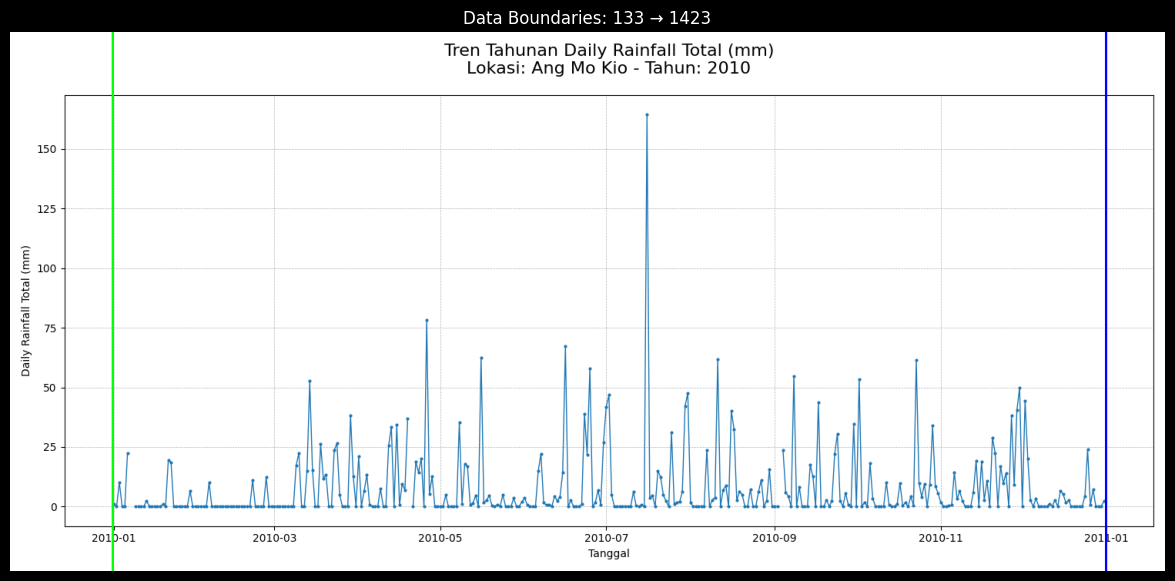

In [7]:
# Load image
image = cv2.imread(str(sample_image))
if image is None:
    raise FileNotFoundError(image_path)

# Your already-computed boundaries
data_start = boundaries["data_start"]
data_end = boundaries["data_end"]

# Draw boundaries
vis = image.copy()
h = vis.shape[0]

cv2.line(vis, (data_start, 0), (data_start, h), (0, 255, 0), 2)  # green
cv2.line(vis, (data_end, 0), (data_end, h), (255, 0, 0), 2)    # red

# Show image
plt.figure(figsize=(15, 7))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title(f"Data Boundaries: {data_start} → {data_end}")
plt.axis("off")
plt.show()

In [16]:
def detect_plot_top_border(
    gray: np.ndarray,
    plot_x_start: int,
    plot_x_end: int,
    min_row: int = 10,
    occupancy_ratio: float = 0.20,
    binarize_thresh: int = 200
) -> int | None:
    plot_region = gray[:, plot_x_start:plot_x_end]

    _, binary_inv = cv2.threshold(
        plot_region,
        binarize_thresh,
        255,
        cv2.THRESH_BINARY_INV
    )

    row_projection = np.sum(binary_inv, axis=1)

    required_pixels = plot_region.shape[1] * occupancy_ratio * 255

    for y in range(min_row, len(row_projection)):
        if row_projection[y] > required_pixels:
            return y

    return None

def extract_y_axis_labels(
    image: np.ndarray,
    plot_x_start: int,
    plot_x_end: int,
    verbose: bool = True
) -> dict:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape[:2]

    left_pad   = 75
    right_pad  = 30
    y_top_frac = 0.0
    y_bot_frac = 0.90

    y0 = int(h * y_top_frac)
    y1 = int(h * y_bot_frac)
    x1 = max(1, plot_x_start - right_pad)
    x0 = max(0, x1 - left_pad)

    roi = gray[y0:y1, x0:x1]

    # binarize (same as debug)
    roi_bin = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    data = pytesseract.image_to_data(
        roi_bin,
        config="--oem 3 --psm 6 outputbase digits",
        output_type=pytesseract.Output.DICT
    )

    labels = []
    roi_w = roi.shape[1]
    x_cut = int(0.5 * roi_w)  # avoid axis line area (dynamic, not hardcoded 100)

    for i, txt in enumerate(data["text"]):
        txt = (txt or "").strip()
        if not txt.isdigit():
            continue

        val = int(txt)
        if val >= 200:
            continue

        x, y, ww, hh = data["left"][i], data["top"][i], data["width"][i], data["height"][i]

        # Skip boxes too far right inside ROI (often axis/grid noise)
        if x + ww > x_cut:
            continue

        # Optional: skip tiny garbage boxes
        if ww < 6 or hh < 8:
            continue

        # convert ROI coords -> global coords
        cx = x0 + x + ww / 2
        cy = y0 + y + hh / 2

        labels.append({"value": val, "x": cx, "y": cy})

    if len(labels) < 2:
        if verbose:
            detected = [t.strip() for t in data["text"] if (t or "").strip()]
            print("[DEBUG] ROI coords:", (x0, y0, x1, y1))
            print("[DEBUG] Raw detected texts (first 30):", detected[:30])
        raise ValueError("Insufficient Y-axis labels detected")

    labels_by_y = sorted(labels, key=lambda d: d["y"], reverse=True)

    uniq = []
    seen = set()
    for item in labels_by_y:
        if item["value"] in seen:
            continue
        uniq.append(item)
        seen.add(item["value"])
        if len(uniq) >= 2:
            break

    if len(uniq) < 2:
        raise ValueError("Need at least 2 distinct labels to estimate zero")

    low, high = uniq[0], uniq[1]  # low: bottom tick (largest y)
    dy = high["y"] - low["y"]
    dv = high["value"] - low["value"]

    if dv == 0:
        raise ValueError("Can't compute scale (dv=0)")

    pixel_per_unit = abs(dy) / abs(dv)

    # Predict y for 0 (same concept as before, but based on bottom tick)
    zero_y = low["y"] + low["value"] * pixel_per_unit
    labels.append({"value": 0, "x": low["x"], "y": float(zero_y)})

    # Extrapolate max using top border (keep your logic)
    top_border_y = detect_plot_top_border(gray, plot_x_start, plot_x_end)
    if top_border_y is not None:
        max_label = max(labels, key=lambda l: l["value"])
        delta_pixel = max_label["y"] - top_border_y
        max_value = max_label["value"] + delta_pixel / pixel_per_unit

        labels.append({"value": float(max_value), "x": max_label["x"], "y": float(top_border_y)})

        if verbose:
            print(f"[INFO] Extrapolated max value ≈ {max_value:.2f}")

    return {l["value"]: (l["x"], l["y"]) for l in sorted(labels, key=lambda l: l["value"])}


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
detect_plot_top_border(
    gray,
    plot_x_start = boundaries['data_start'],
    plot_x_end = boundaries['data_end'],
    min_row = 10,
    occupancy_ratio= 0.20,
    binarize_thresh = 200
)

labels=extract_y_axis_labels(image, plot_x_start=boundaries['data_start'], plot_x_end=boundaries['data_end'])
labels

[INFO] Extrapolated max value ≈ 172.44


{0: (57.5, 617.0),
 5: (52.0, 385.0),
 25: (51.5, 539.0),
 50: (51.5, 462.0),
 100: (48.0, 307.0),
 125: (48.0, 230.0),
 150: (48.0, 152.0),
 172.43589743589743: (48.0, 82.0)}

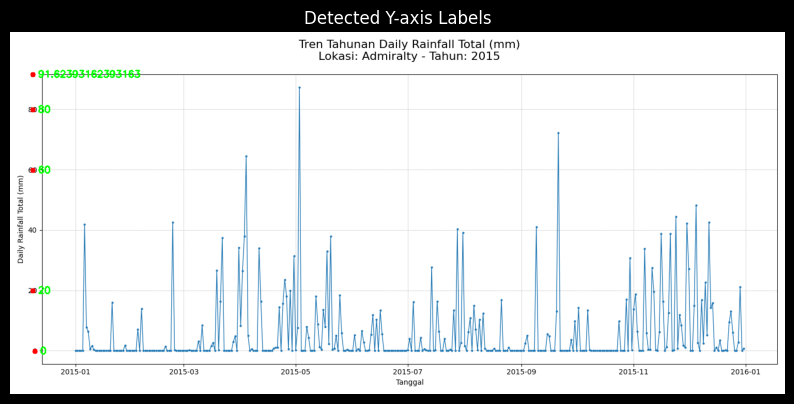

In [10]:
# Copy image for visualization
vis = image.copy()

# Draw labels
for value, (x, y) in labels.items():
    x, y = int(x), int(y)

    # Draw point
    cv2.circle(vis, (x, y), 5, (0, 0, 255), -1)

    # Draw text
    cv2.putText(
        vis,
        str(value),
        (x + 10, y + 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 255, 0),
        2
    )

# Show result
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Detected Y-axis Labels")
plt.axis("off")
plt.show()

Boundaries before: {'data_start': 133, 'data_end': 1423}
[135.0, 344.0, 559.0, 774.0, 993.0, 1209.0, 1424.0]
Boundaries after: {'data_start': 134, 'data_end': 1422}
[INFO] Extrapolated max ≈ 109.59


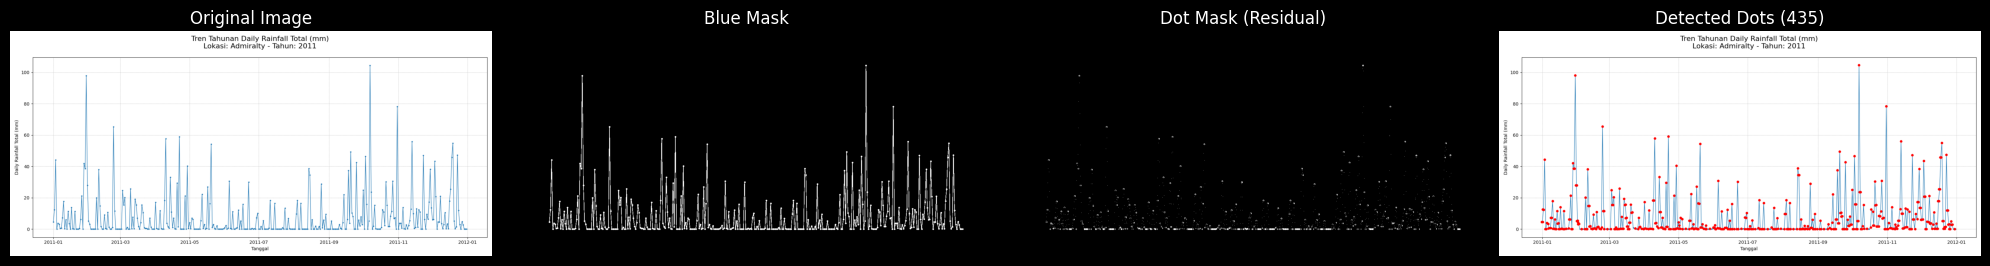

{'data_start': 134, 'data_end': 1422}


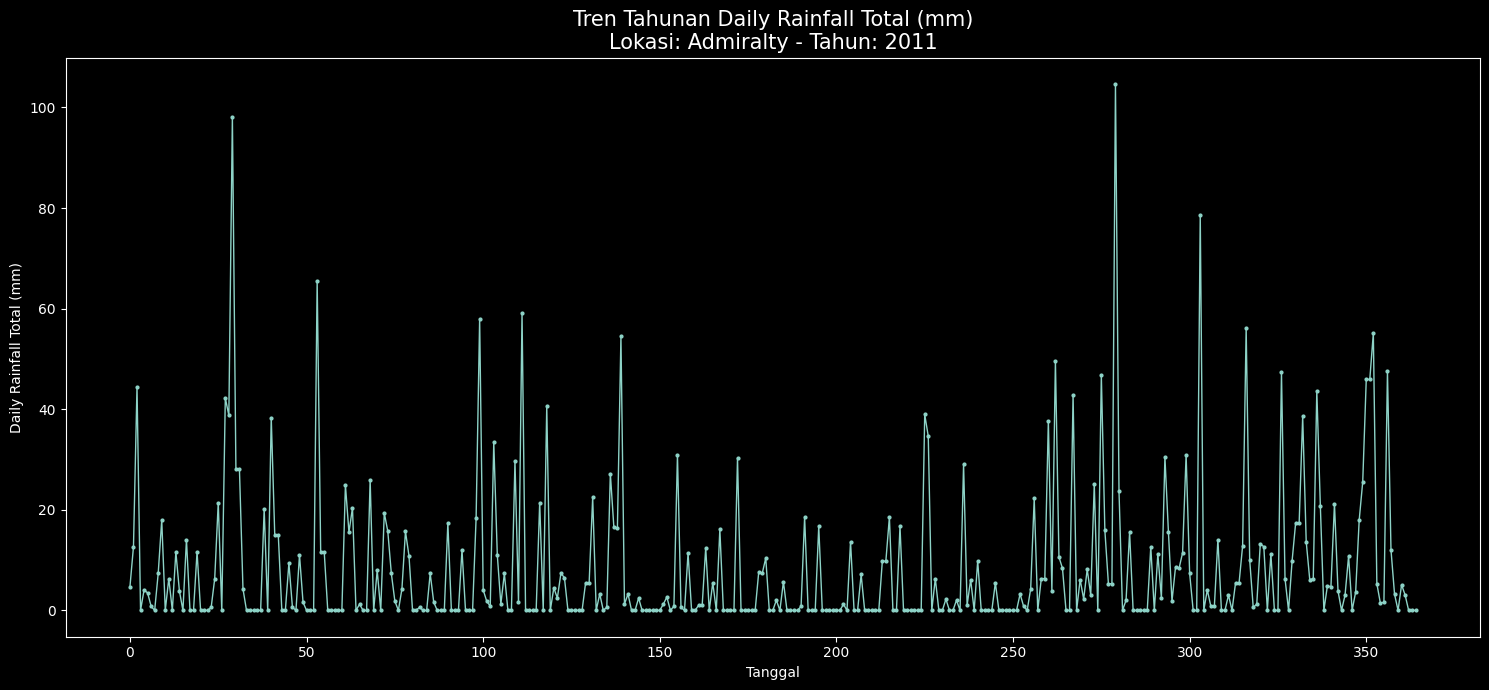

In [ ]:
r()

location = 'Admiralty'
year = 2011

sample_image=config.paths.raw/f'Train/{location}/Plot_Daily_Rainfall_Total_mm_{year}.png'
image = cv2.imread(str(sample_image))

rainfall = extraction.extract_rainfall_from_plot(
    image_path=str(sample_image),
    total_days=365, debug=True
)

plt.figure(figsize=(15, 7))
plt.plot(rainfall, marker='o', linewidth=1, markersize=2)
plt.ylabel('Daily Rainfall Total (mm)')
plt.xlabel('Tanggal')

plt.title(f'Tren Tahunan Daily Rainfall Total (mm)\nLokasi: {location} - Tahun: {year}', fontsize=15)
plt.tight_layout()
plt.show()

# **Chart Extraction**

In [ ]:
extraction.process_all_locations(
    input_root=config.paths.raw/'Train',
    output_dir=config.paths.interim/'extract',
    verbose=True
)

Extracting rainfall: 100%|██████████| 416121/416121 [23:00<00:00, 301.36rows/s]


# **Merge Extracted Data**

In [ ]:
train = extraction.build_training_dataset(
    features_dir=config.paths.interim/"merge/train/",
    targets_dir=config.paths.interim/"extract",
    output_csv=config.paths.interim/"train.csv"
)

Merging locations: 100%|██████████| 44/44 [00:01<00:00, 26.48it/s]



✅ Final training dataset saved to: ..\data\process\train.csv
   Rows: 416,121
   Columns: 11


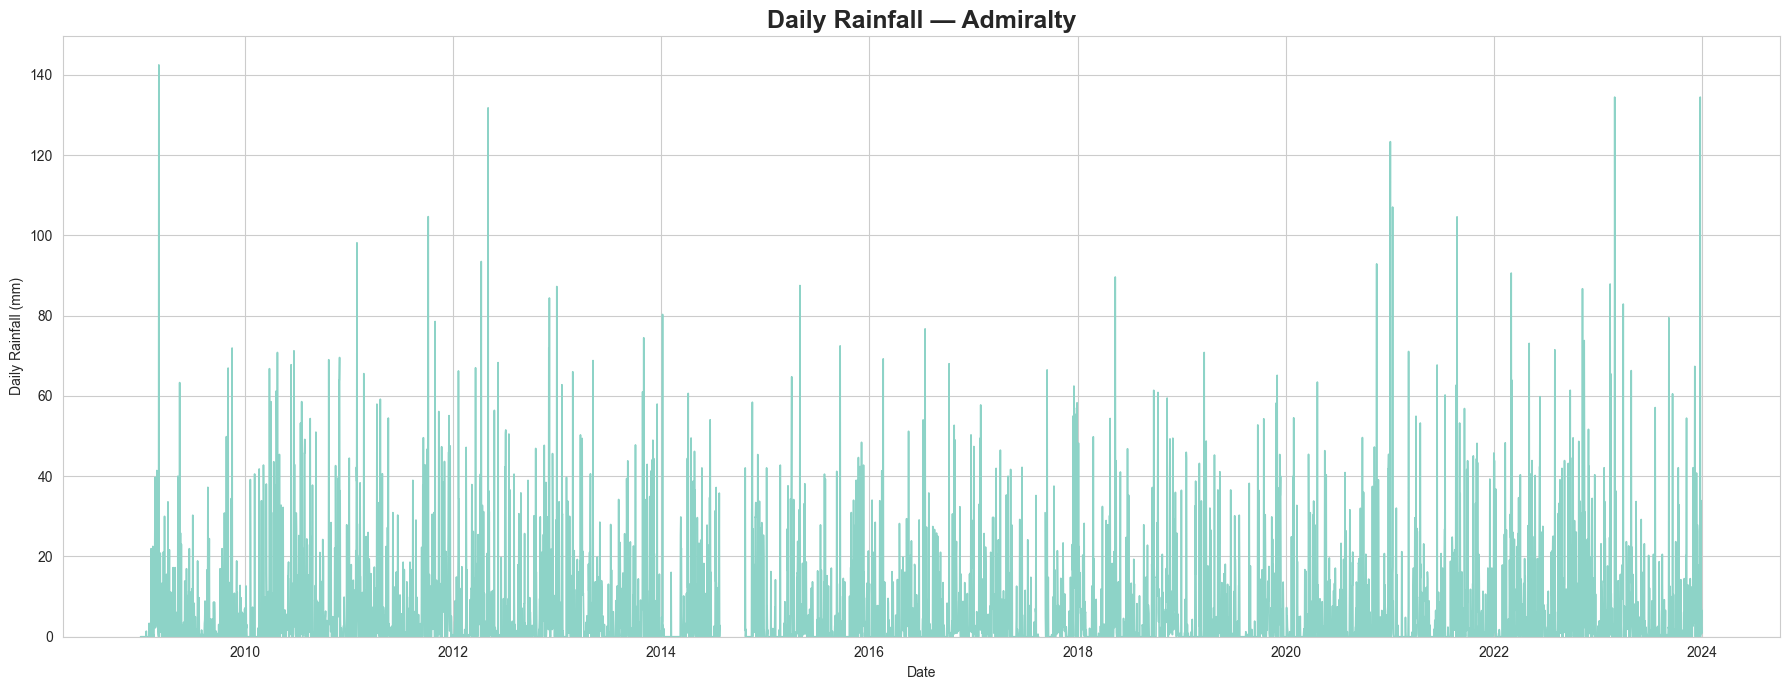

In [ ]:
def plot_daily_rainfall_by_location(
    df: pd.DataFrame,
    location: str,
    *,
    save_path: str | Path | None = None,
    show: bool = True,
    figsize: tuple = (18, 7),
    style: str = "whitegrid"
):
    required_cols = {"date", "daily_rainfall_total_mm", "location"}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df_loc = (
        df[df["location"] == location]
        .sort_values("date")
        .copy()
    )

    if df_loc.empty:
        available = sorted(df["location"].unique())
        raise ValueError(
            f"Location '{location}' not found.\nAvailable locations: {available}"
        )

    sns.set_style(style)
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(
        df_loc["date"],
        df_loc["daily_rainfall_total_mm"],
        linewidth=1.2
    )

    ax.set_title(
        f"Daily Rainfall — {location}",
        fontsize=18,
        fontweight="bold"
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Daily Rainfall (mm)")
    ax.set_ylim(bottom=0)

    fig.tight_layout()

    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=150)

    if show:
        plt.show()
    else:
        plt.close(fig)

def load_training_data(csv_path: str | Path) -> pd.DataFrame:
    csv_path = Path(csv_path)
    if not csv_path.exists():
        raise FileNotFoundError(csv_path)

    return pd.read_csv(csv_path, parse_dates=["date"])


df = load_training_data(config.paths.interim/"train_1226.csv")

plot_daily_rainfall_by_location(
    df,
    location="Admiralty"
)

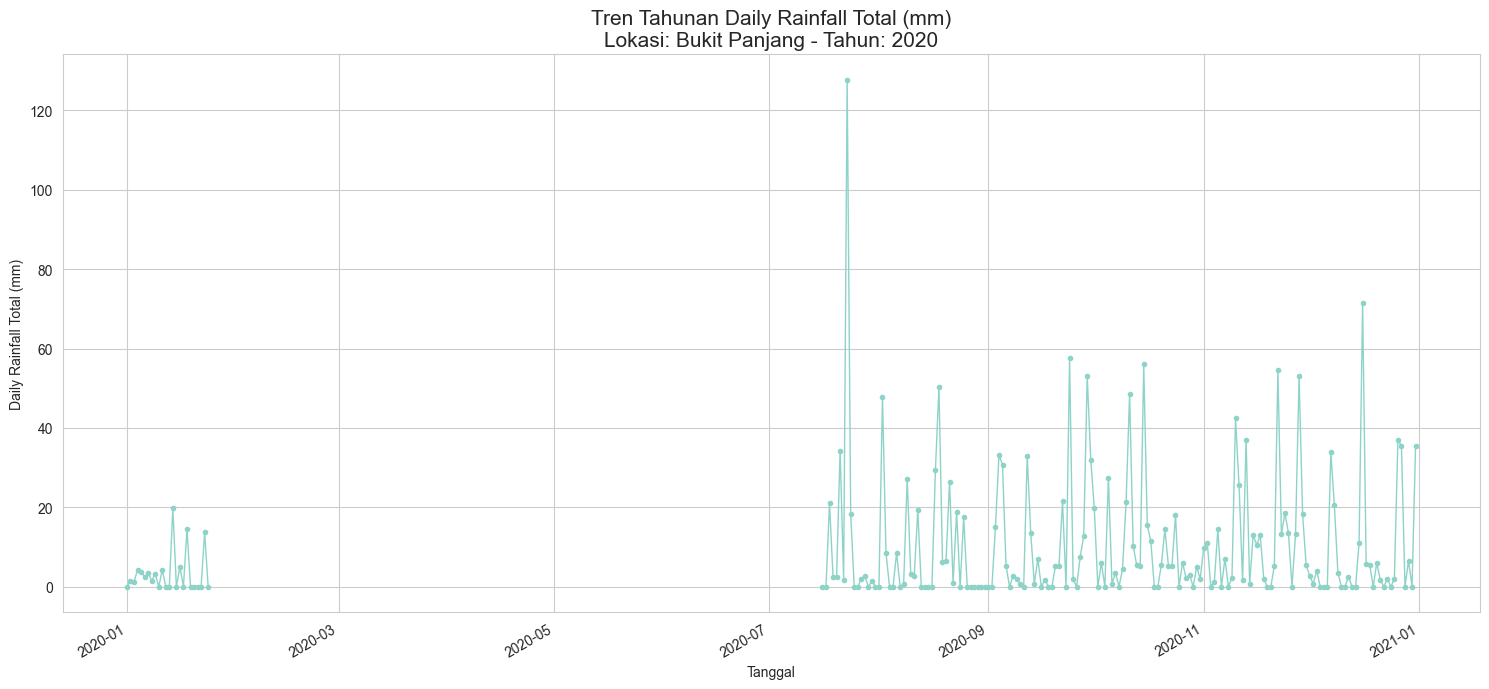

In [ ]:
def plot_daily_rainfall_by_location_and_year(
    df: pd.DataFrame,
    location: str,
    year: int,
    *,
    save_path: str | Path | None = None,
    show: bool = True,
    figsize: tuple = (15, 7),
    style: str = "whitegrid"
):
    required_cols = {"date", "daily_rainfall_total_mm", "location"}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df_loc = df[df["location"] == location].copy()
    if df_loc.empty:
        raise ValueError(
            f"Location '{location}' not found. "
            f"Available: {sorted(df['location'].unique())}"
        )

    df_year = df_loc[df_loc["date"].dt.year == year].sort_values("date")
    if df_year.empty:
        raise ValueError(f"No data for year {year} at location '{location}'")

    sns.set_style(style)
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(
        df_year["date"],
        df_year["daily_rainfall_total_mm"],
        linewidth=1,
        marker="o",
        markersize=3,
    )

    ax.set_title(
        f"Daily Rainfall — {location} ({year})",
        fontsize=15,
        fontweight="bold"
    )

    ax.set_ylabel('Daily Rainfall Total (mm)')
    ax.set_xlabel('Tanggal')

    ax.set_title('Tren Tahunan Daily Rainfall Total (mm)\nLokasi: Bukit Panjang - Tahun: 2020', fontsize=15)

    fig.autofmt_xdate()

    fig.tight_layout()

    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=150)

    if show:
        plt.show()
    else:
        plt.close(fig)


df = load_training_data(config.paths.interim/"train_1226.csv")

plot_daily_rainfall_by_location_and_year(
    df,
    location="Bukit_Panjang",
    year=2020
)

In [ ]:
folder_total = config.paths.interim/'train_1226.csv'
lengkap = pd.read_csv(folder_total)
lengkap.head()

,date,highest_30_min_rainfall_mm,highest_60_min_rainfall_mm,highest_120_min_rainfall_mm,mean_temperature_c,maximum_temperature_c,minimum_temperature_c,mean_wind_speed_kmh,max_wind_speed_kmh,daily_rainfall_total_mm,location
0,2009-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Admiralty
1,2009-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Admiralty
2,2009-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Admiralty
3,2009-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Admiralty
4,2009-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Admiralty


In [154]:
lengkap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416121 entries, 0 to 416120
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   date                         416121 non-null  object 
 1   highest_30_min_rainfall_mm   135603 non-null  float64
 2   highest_60_min_rainfall_mm   135600 non-null  float64
 3   highest_120_min_rainfall_mm  135603 non-null  float64
 4   mean_temperature_c           117569 non-null  float64
 5   maximum_temperature_c        136855 non-null  float64
 6   minimum_temperature_c        136808 non-null  float64
 7   mean_wind_speed_kmh          136259 non-null  float64
 8   max_wind_speed_kmh           101303 non-null  float64
 9   daily_rainfall_total_mm      413298 non-null  float64
 10  location                     416121 non-null  object 
dtypes: float64(9), object(2)
memory usage: 34.9+ MB


In [3]:
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import joblib
import pandas as pd
import numpy as np
from pathlib import Path

from src.config import (
    CLEAN_DIR,
    MODEL_DIR,
    INFERENCE_DIR,
    RAIN_EXTREME_COLUMNS,
    METEOROGICAL_COLUMNS
)
from src.model import (
    build_feature_pipeline,
    build_preprocessor,
    build_model,
    build_pipeline
)

print("Loading data...")
train = pd.read_csv(CLEAN_DIR / "train_1226.csv")

train.sort_values(["date", "location"], inplace=True)

X = train.drop(columns=["daily_rainfall_total_mm"])
y = (train["daily_rainfall_total_mm"].fillna(0)>0.1).astype(int)

pipe = build_pipeline(model_type='classifier')

tscv = TimeSeriesSplit(n_splits=5)

print("Cross validating...")
# scores = cross_val_score(
#     pipe,
#     X,
#     y,
#     cv=tscv,
#     scoring="neg_mean_squared_error",
#     n_jobs=-1
# )

# print("MSE per fold:", -scores)
# print("Mean MSE:", -scores.mean())

print("Fitting final model...")
pipe.fit(X, y)

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, classification_report

proba = pipe.predict_proba(X)[:, 1]

for t in [0.35, 0.45, 0.55, 0.65]:
    y_pred = (proba >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y, y_pred))

Loading data...
Cross validating...
Fitting final model...

Threshold = 0.35
              precision    recall  f1-score   support

           0       0.83      0.35      0.49    214693
           1       0.57      0.92      0.71    201428

    accuracy                           0.63    416121
   macro avg       0.70      0.64      0.60    416121
weighted avg       0.70      0.63      0.60    416121


Threshold = 0.45
              precision    recall  f1-score   support

           0       0.78      0.44      0.56    214693
           1       0.59      0.87      0.71    201428

    accuracy                           0.65    416121
   macro avg       0.69      0.66      0.64    416121
weighted avg       0.69      0.65      0.63    416121


Threshold = 0.55
              precision    recall  f1-score   support

           0       0.64      0.86      0.73    214693
           1       0.76      0.48      0.59    201428

    accuracy                           0.67    416121
   macro avg   

In [5]:
y_pred = pipe.predict(X)
y_proba = pipe.predict_proba(X)[:, 1]

precision, recall, thresholds = precision_recall_curve(
    y.values, y_proba
)

ap = average_precision_score(y, y_proba)

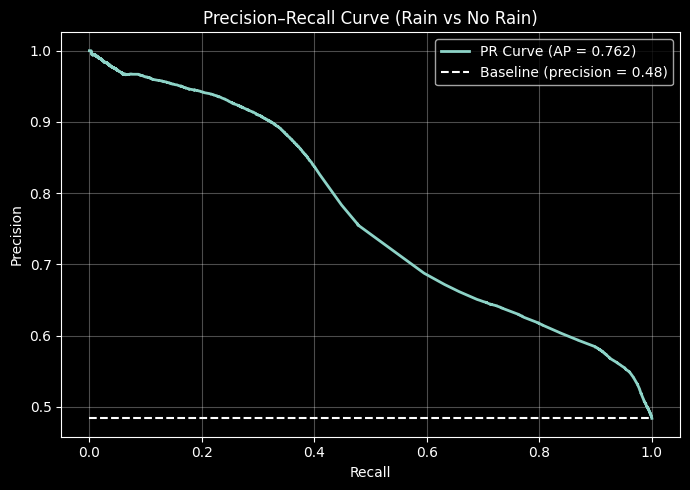

In [6]:
y_true = y
plt.figure(figsize=(7, 5))
plt.plot(
    recall,
    precision,
    label=f"PR Curve (AP = {ap:.3f})",
    linewidth=2
)

# baseline (random classifier)
baseline = y_true.mean()
plt.hlines(
    baseline,
    xmin=0,
    xmax=1,
    linestyles="dashed",
    label=f"Baseline (precision = {baseline:.2f})"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Rain vs No Rain)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

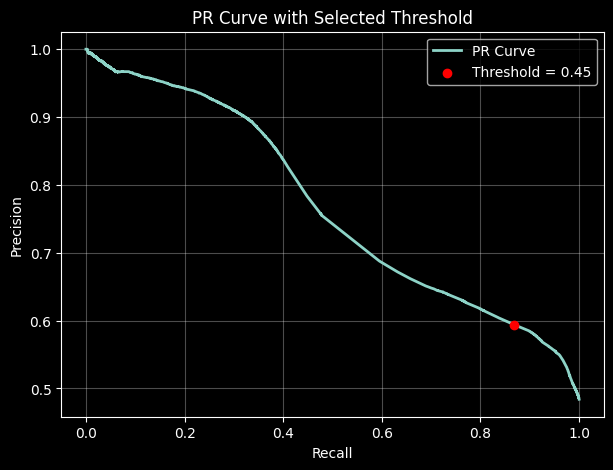

In [7]:
target_threshold = 0.45

idx = np.argmin(np.abs(thresholds - target_threshold))

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label="PR Curve", linewidth=2)

plt.scatter(
    recall[idx],
    precision[idx],
    color="red",
    zorder=3,
    label=f"Threshold = {target_threshold}"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve with Selected Threshold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()